
# AMS-UNet
This notebook contains the code for code for training and testing the AMS-UNET model, in order to start training the assumption is the data pre-processing is already compleyed

before starting create the following folders in the root folder:
```
- AMSUNET: root folder
    |
    |_ data 
    |   |_ train: folder for training data
    |   |   |_ image: folder contains training images
    |   |   |_ label: folder contains training masks
    |   |
    |   |_ test: folder for testing data
    |   |   |_ image: folder contains testing images
    |   |   |_ label: folder contains testing masks
    |   |
    |   |_ predictions: folder to save the predicted masks
    |
    |_ trained_models
    |   |_ <trained_model_name>.hdf5: trained model file
    |
    |_ experiments
    |   |_ postprocessed_predictions: folder for saving the postprocessed images
    |   |_ raw_analysis: folder for raw experiment analysis
    |       |_ <file>.csv: CSV containing raw metrics
    |
    |_ ams_uset_notebook.ipynb
    |
    |_ postprocessing.py
    |
    |_ metrics.py
    |
    |_ model.py
        

```

# 1. Loading Libraries

Import necessary Libraries and necessary functions

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt


from model import unet
from data import trainGenerator, testGenerator, saveResult

# 2. Setup Training Variables

In [2]:
# Define the height of the input images
im_height = 512
# Define the width of the input images
im_width = 512


# Path to the folder containing training data (images and labels)
train_folder = './data/data_q4_272/train'
valid_folder = './data/data_q4_272/valid/'
# Path to the folder where trained models will be saved
models_folder = './trained_models'
model_name = 'model1_fullzoom.hdf5'


# Number of epochs for training (how many complete passes through the training data)
epochs = 100
# Batch size for training (number of samples processed before the model updates)
batch_size = 2

In [3]:
# Function to calculate the number of samples in a directory
def count_samples(data_path, subfolder):
    # Get the path to the specific subfolder (e.g., 'image' or 'label')
    folder_path = os.path.join(data_path, subfolder)
    # Count the number of files in the directory
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])


In [4]:
# Count the total number of training images
total_samples = count_samples(train_folder, 'image')

# Dynamically calculate steps per epoch
steps_per_epoch = total_samples // batch_size
if total_samples % batch_size != 0:
    steps_per_epoch += 1  # Add an extra step for leftover samples

# Count the total number of validation images
num_val_samples = count_samples(valid_folder, 'image')

# Dynamically calculate validation steps
validation_steps = num_val_samples // batch_size
if num_val_samples % batch_size != 0:
    validation_steps += 1  # Add an extra step for leftover validation samples

# Print dataset stats
print(f"Total training samples: {total_samples}")
print(f"Total validation samples: {num_val_samples}")
print(f"Batch size: {batch_size}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")


Total training samples: 200
Total validation samples: 22
Batch size: 2
Steps per epoch: 100
Validation steps: 11


# 3. Training Data Generator

In [165]:
# Define data augmentation parameters for the training generator
data_gen_args = dict(
    rotation_range=0.2,         # Randomly rotate images within a range of ±20%
    width_shift_range=0.15,     # Randomly shift the image width by ±5% of the total width
    height_shift_range=0.05,    # Randomly shift the image height by ±5% of the total height
    shear_range=0.05,           # Apply random shearing transformations within ±5% range
    zoom_range=0.5,            # Randomly zoom in/out on images within ±5% range
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='constant',
    cval=0         # Fill any gaps in transformed images using a constant value
)

# Create a data generator for training
myGene = trainGenerator(
    batch_size=batch_size,          # Number of images per batch (defined as `batch_size`)
    train_path=train_folder,        # Path to the folder containing training data (set to `train_folder`)
    image_folder='image',           # Subfolder name containing training images ('image')
    mask_folder='label',            # Subfolder name containing corresponding labels/masks ('label')
    aug_dict=data_gen_args,         # Dictionary of data augmentation parameters (`data_gen_args`)
    save_to_dir=None,               # Augmented images will not be saved to any directory
    target_size=(im_height, im_width)  # Resize all input images and masks to the specified dimensions (`(im_height, im_width)`)
)


# Define a separate data generator function for validation
valGene = trainGenerator(
    batch_size=batch_size,           # Keep the same batch size
    train_path=valid_folder,           # Path to the folder containing validation data
    image_folder='image',            # Subfolder for images
    mask_folder='label',             # Subfolder for masks
    aug_dict={},                     # No augmentation for validation
    save_to_dir=None,                # No need to save output
    target_size=(im_height, im_width)  # Resize images/masks
)



### view one of the images generated by the generator 

notice how the data augmentation is applied on the images

Found 200 images belonging to 1 classes.
Found 200 images belonging to 1 classes.


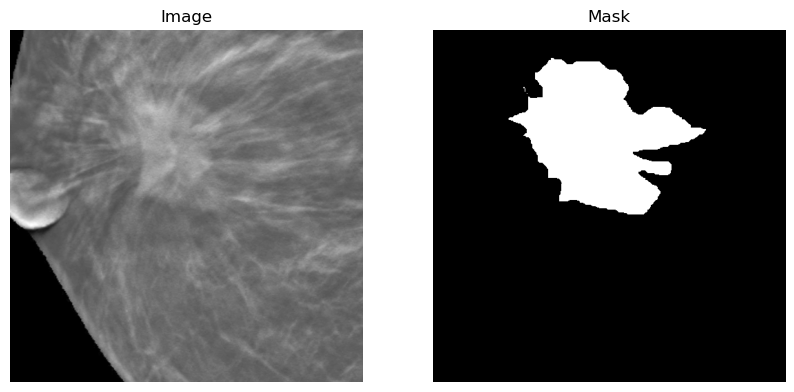

In [166]:
# Get one batch of images and masks from the generator
image_batch, mask_batch = next(myGene)

# Display the first image and its corresponding mask in the batch
plt.figure(figsize=(10, 5))
# Display the image
plt.subplot(1, 2, 1)
plt.imshow(image_batch[0].squeeze(), cmap="gray")  # Use squeeze() to remove extra dimensions
plt.title("Image")
plt.axis("off")
# Display the mask
plt.subplot(1, 2, 2)
plt.imshow(mask_batch[0].squeeze(), cmap="gray")  # Use squeeze() to remove extra dimensions
plt.title("Mask")
plt.axis("off")
plt.show()

# 4. Define and train the model

In [169]:
# Create a U-Net model with the specified input size
# Input size is defined as (im_height, im_width, 1), where 1 represents one channel for grayscale images
model = unet(input_size=(im_height, im_width, 1))

# Define a callback to save the model during training
model_checkpoint = ModelCheckpoint(
    f'{models_folder}/{model_name}',    # Path where the model will be saved
    monitor='val_loss',                     # Monitor the val loss during training
    verbose=1,                          # Print messages about the saving process
    save_best_only=True                 # Save only the model with the best (lowest) loss
)

# Define a learning rate reduction callback
lr_callback = ReduceLROnPlateau(
    monitor='val_loss',            # Monitor val loss to reduce LR
    factor=0.5,                # Reduce learning rate by a factor of 0.5
    patience=3,                # Number of epochs with no improvement before reducing
    verbose=1,                 # Print info
    min_lr=1e-6                # Minimum learning rate
)

# define an early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=5,             # Stop if no improvement after 5 epochs
    verbose=1,              # Print when training stops
    restore_best_weights=True  # Roll back to the best model
)

# Train the U-Net model with validation
history = model.fit_generator(
    myGene,                                 # Training data generator
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valGene,               # Validation data generator
    validation_steps=validation_steps,     # Number of validation batches per epoch
    callbacks=[model_checkpoint, lr_callback]
)


Epoch 1/100


/var/folders/wg/_bw301w169bd2mdb38l8r5j80000gn/T/ipykernel_94740/2288764586.py:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2025-05-23 13:29:51.642733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.9653

2025-05-23 13:30:44.248956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.17465, saving model to ./trained_models/model1_fullzoom.hdf5
100/100 [==============================] - 56s 536ms/step - loss: 0.1866 - accuracy: 0.9653 - val_loss: 0.1746 - val_accuracy: 0.9668 - lr: 1.0000e-04
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.9640
Epoch 2: val_loss improved from 0.17465 to 0.16610, saving model to ./trained_models/model1_fullzoom.hdf5
100/100 [==============================] - 55s 545ms/step - loss: 0.1546 - accuracy: 0.9640 - val_loss: 0.1661 - val_accuracy: 0.9619 - lr: 1.0000e-04
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9618
Epoch 3: val_loss did not improve from 0.16610
100/100 [==============================] - 54s 543ms/step - loss: 0.1595 - accuracy: 0.9618 - val_loss: 0.1684 - val_accuracy: 0.9617 - lr: 1.0000e-04
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 0.1570 - accuracy: 0.9603


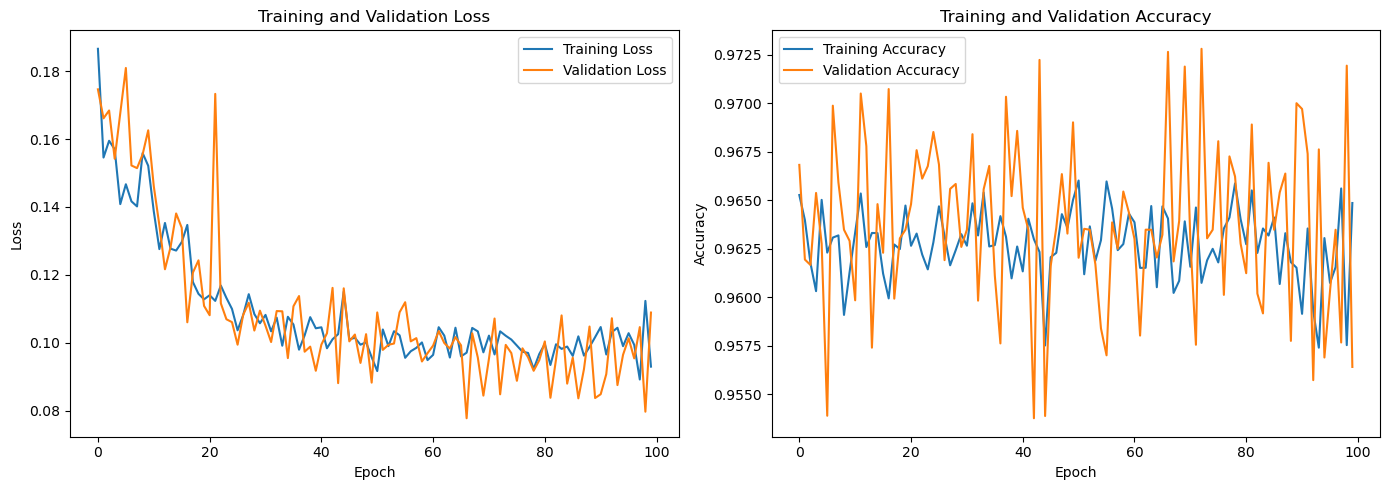

In [170]:

# Visualize the training and validation history
plt.figure(figsize=(14, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy (if available)
plt.subplot(1, 2, 2)
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# 5. Testing the model

### Define the testing variables

In [5]:
# Define the height of the input images for testing
im_height = 1024

# Define the width of the input images for testing
im_width = 1024

# Path to the folder containing testing images
test_folder = './data/data_q4_272/test/image'

# Path to save the predicted masks
predictions_folder = "./data/predictions/"

### Load the trained model

In [32]:
# Load the pre-trained model
model_path = f'{models_folder}/{model_name}' # you can change the model name as u like to use a different model
model_path = './trained_models/model1_full.hdf5'
model = unet(input_size=(im_height, im_width, 1))
model.load_weights(model_path)

### Setup Testing Data Generator

In [33]:
# Count the total number of images in the training folder
total_test_samples = count_samples(test_folder, '')

print(f"Total samples: {total_test_samples}")

Total samples: 50


In [34]:
# Generate test data
testGene = testGenerator(test_folder, target_size=(im_height, im_width))

# Generate test data and collect file names
test_data = list(testGenerator(test_folder, target_size=(512, 512)))
# Separate images and file names
test_images, file_names = zip(*test_data)

### Run the prediction on the testing data

In [35]:
# Run predictions
import random
random.seed(10)
results = model.predict(testGene, steps=total_test_samples, verbose=1)

2025-05-23 15:35:54.194397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 14s 272ms/step


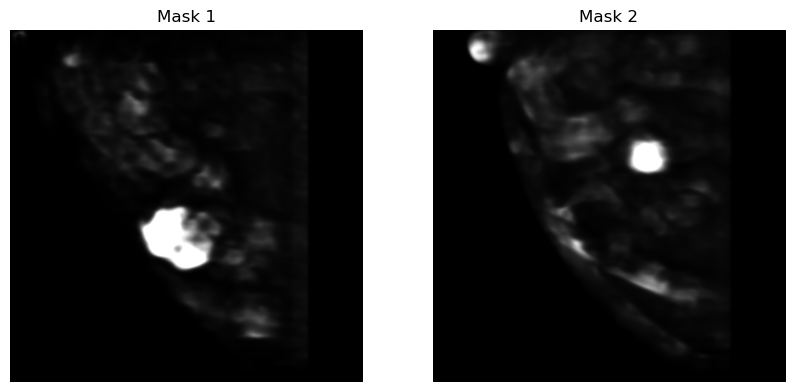

In [73]:
# Display the first 2 predicted masks
plt.figure(figsize=(10, 5))
# Display the mask
plt.subplot(1, 2, 1)
plt.imshow(results[0,:,:,:].squeeze(), cmap="gray")  # Use squeeze() to remove extra dimensions
plt.title("Mask 1")
plt.axis("off")
# Display the mask
plt.subplot(1, 2, 2)
plt.imshow(results[20,:,:,:].squeeze(), cmap="gray")  # Use squeeze() to remove extra dimensions
plt.title("Mask 2")
plt.axis("off")
plt.show()

In [37]:
# Save results
saveResult(predictions_folder, results, file_names)

## 5.1 Post Processing

In [38]:
from postprocessing import gaus_otsu_thresh

In [39]:
# Define the folder where post-processed masks will be saved
postprocessed_masks_folder = './experiments/postprocessed_predictions/'

In [41]:
# Apply Gaussian blur and Otsu thresholding on the predicted masks
# gaus_otsu_thresh: Function to perform Gaussian blur followed by Otsu thresholding
# predictions_folder: Path to the folder containing predicted masks (input folder)
# postprocessed_masks_folder: Path to save the post-processed masks (output folder)

processed_images = gaus_otsu_thresh(predictions_folder, postprocessed_masks_folder)

applying gaussian blur 15 then Otsu on images in ./data/predictions/
48.png
49.png
8.png
9.png
14.png
28.png
29.png
15.png
17.png
16.png
12.png
13.png
39.png
11.png
10.png
38.png
35.png
21.png
20.png
34.png
22.png
36.png
37.png
23.png
27.png
33.png
32.png
26.png
18.png
30.png
24.png
25.png
31.png
19.png
4.png
42.png
43.png
5.png
41.png
7.png
6.png
40.png
44.png
2.png
3.png
45.png
1.png
47.png
46.png
0.png


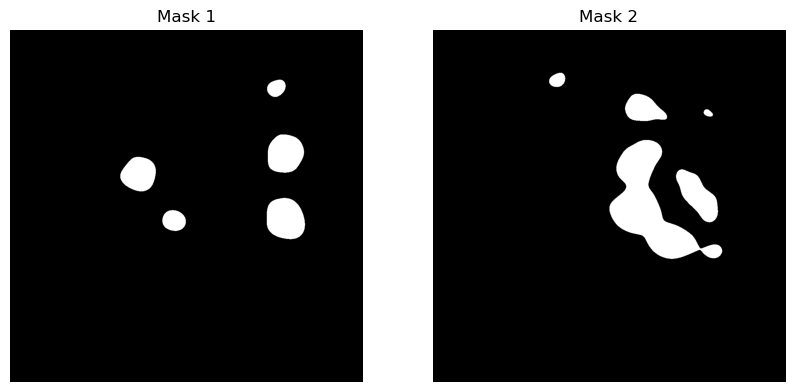

In [42]:
# Display the first 2 predicted masks
plt.figure(figsize=(10, 5))
# Display the mask
plt.subplot(1, 2, 1)
plt.imshow(processed_images[0], cmap="gray")  # Use squeeze() to remove extra dimensions
plt.title("Mask 1")
plt.axis("off")
# Display the mask
plt.subplot(1, 2, 2)
plt.imshow(processed_images[1], cmap="gray")  # Use squeeze() to remove extra dimensions
plt.title("Mask 2")
plt.axis("off")
plt.show()

## 5.2 calculate the evaluation metrics

In [43]:
import numpy as np
import pandas as pd
from metrics import find_metrics, tpr, fpr, f_score, iou_score, sensitivity, specificity, accuracy 

In [58]:
# save folder
save_to = './experiments/raw_analysis' # change output folder as needed
no_images = total_test_samples
csv_file_name = 'metrics.csv'

# Load data
label_mono_path = postprocessed_masks_folder # folder for the predictions that we need to analyze
label_truth_path = './data/data_q4_272/test/label/' # ground truth folder

In [59]:

# Metrics
image_list = []
TPR = []
FPR = []
F_SCORE = []
IOU = []
IOU_SCORE = []
SENSITIVITY = []
SPECIFICITY = []
ACCURACY = []
TP = []
TN = []
FP = []
FN = []


In [60]:
i = 0
predictions = os.listdir(label_mono_path)
predictions = [f for f in predictions if f != '.DS_Store']
print('working on {}'.format(label_mono_path))
print(predictions)
labels = os.listdir(label_truth_path)
print(labels)


working on ./experiments/postprocessed_predictions/
['48.png', '49.png', '8.png', '9.png', '14.png', '28.png', '29.png', '15.png', '17.png', '16.png', '12.png', '13.png', '39.png', '11.png', '10.png', '38.png', '35.png', '21.png', '20.png', '34.png', '22.png', '36.png', '37.png', '23.png', '27.png', '33.png', '32.png', '26.png', '18.png', '30.png', '24.png', '25.png', '31.png', '19.png', '4.png', '42.png', '43.png', '5.png', '41.png', '7.png', '6.png', '40.png', '44.png', '2.png', '3.png', '45.png', '1.png', '47.png', '46.png', '0.png']
['48.png', '49.png', '8.png', '9.png', '14.png', '28.png', '29.png', '15.png', '17.png', '16.png', '12.png', '13.png', '39.png', '11.png', '10.png', '38.png', '35.png', '21.png', '20.png', '34.png', '22.png', '36.png', '37.png', '23.png', '27.png', '33.png', '32.png', '26.png', '18.png', '30.png', '24.png', '25.png', '31.png', '19.png', '4.png', '42.png', '43.png', '5.png', '41.png', '7.png', '6.png', '40.png', '44.png', '2.png', '3.png', '45.png', '1.p

In [61]:
for prediction, label in zip(predictions, labels):
    # print(f'analyzing {prediction}') # optional

    # if prediction.lower().endswith('.png'):
        

    total_bg_pxl_truth, total_obj_pxl_truth, tp, tn, fp, fn = find_metrics(label_truth_path + label,
                                                                        label_mono_path + prediction)

    # Append metrics for each image
    image_list.append(prediction)
    TP.append(tp)
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TPR.append(tpr(tp, total_obj_pxl_truth))
    FPR.append(fpr(fp, total_bg_pxl_truth))
    F_SCORE.append(f_score(tp, fp, fn))
    IOU_SCORE.append(iou_score(label_truth_path + label, label_mono_path + prediction))
    SENSITIVITY.append(sensitivity(tp, fn))
    SPECIFICITY.append(specificity(fp, tn))
    ACCURACY.append(accuracy(tp, fp, tn, fn))

    i += 1
    if i % 10 == 0:
        print('analyzed ', i, ' images')
    # else:
    #     continue

# Create a DataFrame
df = pd.DataFrame({
    'Image': image_list,
    'TPR': TPR,
    'FPR': FPR,
    'F-Score': F_SCORE,
    'IOU Score': IOU_SCORE,
    'Sensitivity': SENSITIVITY,
    'Specificity': SPECIFICITY,
    'Accuracy': ACCURACY,
    'TP': TP,
    'TN': TN,
    'FP': FP,
    'FN': FN
})


print('average TPR: ', np.average(TPR))
print('average FPR: ', np.average(FPR))
print('average F-Score: ', np.average(F_SCORE))
print('average IOU: ', np.average(IOU))
print('average sensitivity: ', np.average(SENSITIVITY))
print('average specificity: ', np.average(SPECIFICITY))
print('average accuracy: ', np.average(ACCURACY))
print('average IOU score: ', np.average(IOU_SCORE))

# Save to CSV
df.to_csv(os.path.join(save_to, csv_file_name), index=False)
print(f"Metrics saved to {save_to}/{csv_file_name}")

analyzed  10  images
analyzed  20  images
analyzed  30  images
analyzed  40  images
analyzed  50  images
average TPR:  0.0
average FPR:  0.045571590090231304
average F-Score:  0.0
average IOU:  nan
average sensitivity:  0.0
average specificity:  0.9544284099097686
average accuracy:  0.9278536224365235
average IOU score:  0.28416287986347777
Metrics saved to ./experiments/raw_analysis/metrics.csv


/Users/ahmad/anaconda3/envs/amsunet/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/ahmad/anaconda3/envs/amsunet/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [62]:
df.head()

,Image,TPR,FPR,F-Score,IOU Score,Sensitivity,Specificity,Accuracy,TP,TN,FP,FN
0,48.png,0.0,0.024102,0,0.238059,0.0,0.975898,0.966197,0,1013131,25022,10423
1,49.png,0.0,0.025426,0,0.436818,0.0,0.974574,0.921729,0,966503,25215,56858
2,8.png,0.0,0.019862,0,0.300476,0.0,0.980138,0.947688,0,993723,20137,34716
3,9.png,0.0,0.003218,0,0.316171,0.0,0.996782,0.968920,0,1015986,3280,29310
4,14.png,0.0,0.085321,0,0.053786,0.0,0.914679,0.910264,0,954481,89034,5061
